* https://www.youtube.com/watch?v=zYT5VpQWJAQ
* https://github.com/jeffjay88/Climate_Indices/blob/main/1D_spi_pandas.ipynb

In [1]:
import pandas as pd
import numpy as np
import netCDF4 as nc
import xarray as xr
from scipy import stats as st
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.basemap import shiftgrid

In [2]:
fp = '../data/precip.mon.total.2.5x2.5.v7.nc'
ds = nc.Dataset(fp)
ds

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format NETCDF3):
    history: Created 01/2016 based on V7 data obtained via ftp
    title: GPCC Precipitation Full V7 2.5x2.5 Monthly Total
    Conventions: CF 1.0
    References: http://www.psl.noaa.gov/data/gridded/data.gpcc.html
    Original_Source: http://www.dwd.de/en/FundE/Klima/KLIS/int/GPCC/GPCC.htm
 is the webpage and the data is at ftp://ftp.dwd.de/pub/data/gpcc/download.html
    Reference: Users of the data sets are kindly requested to give feed back and to refer to GPCC publications on this webpage: http://www.dwd.de/bvbw/appmanager/bvbw/dwdwwwDesktop/?_nfpb=true&_pageLabel=_dwdwww_klima_umwelt_datenzentren_wzn&T12404518261141645246564gsbDocumentPath=Content%2FOeffentlichkeit%2FKU%2FKU4%2FKU42%2Fteaser__product__access.html&_state=maximized&_windowLabel=T12404518261141645246564&lastPageLabel=_dwdwww_klima_umwelt_datenzentren_wzn
    original_source: ftp://ftp-anon.dwd.de/pub/data/gpcc/html/fulld

In [3]:
ds.variables.keys()

dict_keys(['lat', 'lon', 'time', 'precip'])

In [4]:
ds = xr.open_dataset(fp)
df = ds.to_dataframe()

In [5]:
df = df.reset_index()
df.head()

,lat,lon,time,precip
0,88.75,1.25,1901-01-01,NaN
1,88.75,1.25,1901-02-01,NaN
2,88.75,1.25,1901-03-01,NaN
3,88.75,1.25,1901-04-01,NaN
4,88.75,1.25,1901-05-01,NaN


In [6]:
df.isna().sum()

lat             0
lon             0
time            0
precip    9125880
dtype: int64

In [7]:
df.shape

(14059008, 4)

In [8]:
central_amazon_data = df[(df['lat']<=1.25) & (df['lat']>=-11.25) & (df['lon']>=288.75) & (df['lon']<=306.25)]

In [9]:
central_amazon_data.isna().sum()

lat       0
lon       0
time      0
precip    0
dtype: int64

In [10]:
central_amazon_data.shape

(65088, 4)

In [11]:
ds_center_amazon = ds.where((ds.lat <= 1.25) & (ds.lat >=-11.25) & (ds.lon >= 288.75) & (ds.lon <= 306.25))

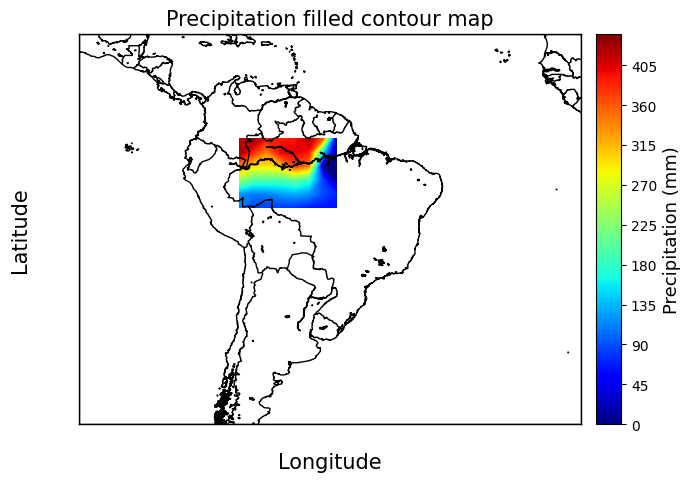

In [12]:
data = ds_center_amazon

lats = data.variables['lat'][:]
lons = data.variables['lon'][:]
precip = data.variables['precip'][:]

###  Section added ################
# map lon values to -180..180 range
f = lambda x: ((x+180) % 360) - 180
lons = f(lons)
# rearange data
ind = np.argsort(lons)
lons = lons[ind]
precip = precip[:, :, ind]

##################################


fig = plt.figure(num=None, figsize=(7, 7) ) 
m = Basemap(projection='cyl', llcrnrlon=-100, llcrnrlat=-50, urcrnrlon=-10, urcrnrlat=20, resolution='i')

lon, lat = np.meshgrid(lons,lats)

x, y = m(lon, lat)

pr = np.squeeze(precip[100,:,:])
# cs = m.pcolor(x, y , pr, cmap='jet')
cs = m.contourf(x, y , pr, cmap='jet', levels = 300)
m.drawcoastlines()
m.drawmapboundary()
m.drawcountries(linewidth=1, linestyle='solid', color='k' ) 
# m.drawmeridians(range(-80, -25, 5), color='k', linewidth=1.0, dashes=[4, 4], labels=[0, 0, 0, 1])
# m.drawparallels(range(-50, 20, 5), color='k', linewidth=1.0, dashes=[4, 4], labels=[1, 0, 0, 0])
plt.ylabel("Latitude", fontsize=15, labelpad=35)
plt.xlabel("Longitude", fontsize=15, labelpad=20)
cbar = m.colorbar(cs, location='right', pad="3%")
cbar.set_label('Precipitation (mm)', fontsize=13)
plt.title('Precipitation filled contour map', fontsize=15)
plt.show()

In [51]:
#Standardized Precipitation Index Function
def spi(ds, thresh):
    #ds - data ; thresh - time interval / scale
    
    #Rolling Mean / Moving Averages
    ds_ma = ds.rolling(thresh, center=False).mean()
    
    #Natural log of moving averages
    ds_In = np.log(ds_ma)
    ds_In[np.isinf(ds_In) == True] = np.nan  #Change infinity to NaN
    
    #Overall Mean of Moving Averages
    ds_mu = np.nanmean(ds_ma)
    
    #Summation of Natural log of moving averages
    ds_sum = np.nansum(ds_In)
        
    #Computing essentials for gamma distribution
    n = len(ds_In[thresh-1:])                  #size of data
    A = np.log(ds_mu) - (ds_sum/n)             #Computing A
    alpha = (1/(4*A))*(1+(1+((4*A)/3))**0.5)   #Computing alpha  (a)
    beta = ds_mu/alpha                         #Computing beta (scale)
    
    #Gamma Distribution (CDF)
    gamma = st.gamma.cdf(ds_ma, a=alpha, scale=beta)  
    
    #Standardized Precipitation Index   (Inverse of CDF)
    norm_spi = st.norm.ppf(gamma, loc=0, scale=1)  #loc is mean and scale is standard dev.
    
    return ds_ma, ds_In, ds_mu, ds_sum, n, A, alpha, beta, gamma, norm_spi

In [100]:
central_amazon_data[(central_amazon_data['lat'] == 1.25) & (central_amazon_data['lon'] == 288.75)]['precip'].reset_index(drop=True)

0       114.550003
1       182.850006
2       241.649994
3       285.989990
4       346.690002
           ...    
1351    243.339996
1352    301.600006
1353    135.009995
1354    126.669998
1355    166.910004
Name: precip, Length: 1356, dtype: float32

In [ ]:
pd.options.mode.chained_assignment = None  # default='warn'

In [59]:
dt = central_amazon_data[(central_amazon_data['lat'] == 1.25) & (central_amazon_data['lon'] == 288.75)]

In [60]:
times = [3, 6, 9, 12, 24]
for i in times:
    x = spi(dt['precip'], i)
    dt['spi_'+str(i)] = x[9]

In [61]:
dt

,lat,lon,time,precip,spi_3,spi_6,spi_9,spi_12,spi_24
6990180,1.25,288.75,1901-01-01,114.550003,NaN,NaN,NaN,NaN,NaN
6990181,1.25,288.75,1901-02-01,182.850006,NaN,NaN,NaN,NaN,NaN
6990182,1.25,288.75,1901-03-01,241.649994,-1.000344,NaN,NaN,NaN,NaN
6990183,1.25,288.75,1901-04-01,285.989990,-0.186801,NaN,NaN,NaN,NaN
6990184,1.25,288.75,1901-05-01,346.690002,0.474674,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
6991531,1.25,288.75,2013-08-01,243.339996,0.362796,0.813030,-0.431275,-1.618737,-0.226168
6991532,1.25,288.75,2013-09-01,301.600006,0.078588,0.891967,0.234353,-1.237123,-0.271634
6991533,1.25,288.75,2013-10-01,135.009995,-0.321124,0.157054,0.402297,-1.644491,-0.358287
6991534,1.25,288.75,2013-11-01,126.669998,-0.875549,-0.387803,0.199318,-1.220368,-0.546027


In [35]:
central_amazon_spi = central_amazon_data.copy()
times = [3, 6, 9, 12, 24]
for t in times:
    central_amazon_spi['spi_'+str(t)] = np.nan

In [55]:
times = [3, 6, 9, 12, 24]
for lat in central_amazon_data['lat'].unique():
    for lon in central_amazon_data['lon'].unique():
        for t in times:
            series = central_amazon_spi[(central_amazon_spi['lat']==lat) & (central_amazon_spi['lon']==lon)]['precip']
            x = spi(series, t)
            spi_value = x[9]
            central_amazon_spi.loc[(central_amazon_spi['lat']==lat) & (central_amazon_spi['lon']==lon), 'spi_'+str(t)] = spi_value

c:\Users\mathe\my_git_repositories\climate-data-preprocessing\.venv\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [64]:
central_amazon_spi.isna().sum()

lat          0
lon          0
time         0
precip       0
spi_3       96
spi_6      240
spi_9      384
spi_12     528
spi_24    1104
dtype: int64

In [56]:
central_amazon_spi[(central_amazon_data['lat'] == 1.25) & (central_amazon_data['lon'] == 288.75)]

,lat,lon,time,precip,spi_3,spi_6,spi_9,spi_12,spi_24
6990180,1.25,288.75,1901-01-01,114.550003,NaN,NaN,NaN,NaN,NaN
6990181,1.25,288.75,1901-02-01,182.850006,NaN,NaN,NaN,NaN,NaN
6990182,1.25,288.75,1901-03-01,241.649994,-1.000344,NaN,NaN,NaN,NaN
6990183,1.25,288.75,1901-04-01,285.989990,-0.186801,NaN,NaN,NaN,NaN
6990184,1.25,288.75,1901-05-01,346.690002,0.474674,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
6991531,1.25,288.75,2013-08-01,243.339996,0.362796,0.813030,-0.431275,-1.618737,-0.226168
6991532,1.25,288.75,2013-09-01,301.600006,0.078588,0.891967,0.234353,-1.237123,-0.271634
6991533,1.25,288.75,2013-10-01,135.009995,-0.321124,0.157054,0.402297,-1.644491,-0.358287
6991534,1.25,288.75,2013-11-01,126.669998,-0.875549,-0.387803,0.199318,-1.220368,-0.546027


In [62]:
dt

,lat,lon,time,precip,spi_3,spi_6,spi_9,spi_12,spi_24
6990180,1.25,288.75,1901-01-01,114.550003,NaN,NaN,NaN,NaN,NaN
6990181,1.25,288.75,1901-02-01,182.850006,NaN,NaN,NaN,NaN,NaN
6990182,1.25,288.75,1901-03-01,241.649994,-1.000344,NaN,NaN,NaN,NaN
6990183,1.25,288.75,1901-04-01,285.989990,-0.186801,NaN,NaN,NaN,NaN
6990184,1.25,288.75,1901-05-01,346.690002,0.474674,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
6991531,1.25,288.75,2013-08-01,243.339996,0.362796,0.813030,-0.431275,-1.618737,-0.226168
6991532,1.25,288.75,2013-09-01,301.600006,0.078588,0.891967,0.234353,-1.237123,-0.271634
6991533,1.25,288.75,2013-10-01,135.009995,-0.321124,0.157054,0.402297,-1.644491,-0.358287
6991534,1.25,288.75,2013-11-01,126.669998,-0.875549,-0.387803,0.199318,-1.220368,-0.546027


In [67]:
drought_series = central_amazon_spi[['lat', 'lon', 'time', 'spi_12']].copy()

In [69]:
drought_series.fillna(0, inplace=True)

In [90]:
k = -1
drought_series['D'] = drought_series['spi_12'].apply(lambda x: 1 if x <= k else 0)

In [91]:
drought_series

,lat,lon,time,spi_12,D
6990180,1.25,288.75,1901-01-01,0.000000,0
6990181,1.25,288.75,1901-02-01,0.000000,0
6990182,1.25,288.75,1901-03-01,0.000000,0
6990183,1.25,288.75,1901-04-01,0.000000,0
6990184,1.25,288.75,1901-05-01,0.000000,0
...,...,...,...,...,...
7977343,-11.25,306.25,2013-08-01,0.057049,0
7977344,-11.25,306.25,2013-09-01,-0.067735,0
7977345,-11.25,306.25,2013-10-01,0.131356,0
7977346,-11.25,306.25,2013-11-01,0.404663,0


<Axes: xlabel='time'>

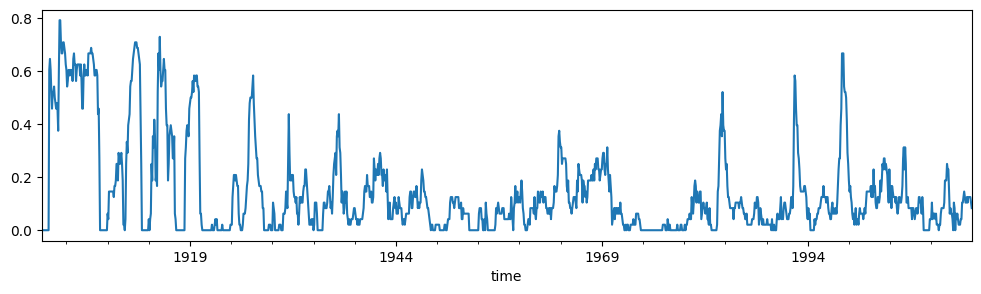

In [92]:
drought_series[['time', 'D']].groupby('time').apply(np.mean).plot(figsize=(12,3))